## Initialization settings - Load the packages

Load the required packages and define the function to fix the random seed

In [1]:
# The initialization settings - Load the required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import tensorflow.keras as tkeras
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from statsmodels.tsa.seasonal import seasonal_decompose
import random

# Note that 'edward2' is not a built-in Python package of Kaggle.
# When you first load it, you need to install it using 'pip'.
import os
os.system('pip install edward2')
import edward2 as ed2

# Define the function to fix the random seed
def set_seed(seed = 0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

## Part 1 - The exploration on the Wine data set

Load the Wine data set  
You first need to upload this data set to the following path on Kaggle:  
**'../input/wine-dataset/wine.csv'**  

Perform some initial analyses on Wine data set

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed.acidity         4898 non-null   float64
 1   volatile.acidity      4898 non-null   float64
 2   citric.acid           4898 non-null   float64
 3   residual.sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free.sulfur.dioxide   4898 non-null   float64
 6   total.sulfur.dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
 12  type                  4898 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 497.6 KB
None


,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,type
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909,1.964475
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639,0.836162
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000,1.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000,1.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000,2.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000,3.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000,3.000000


,count
quality,
3,20
4,163
5,1457
6,2198
7,880
8,175
9,5


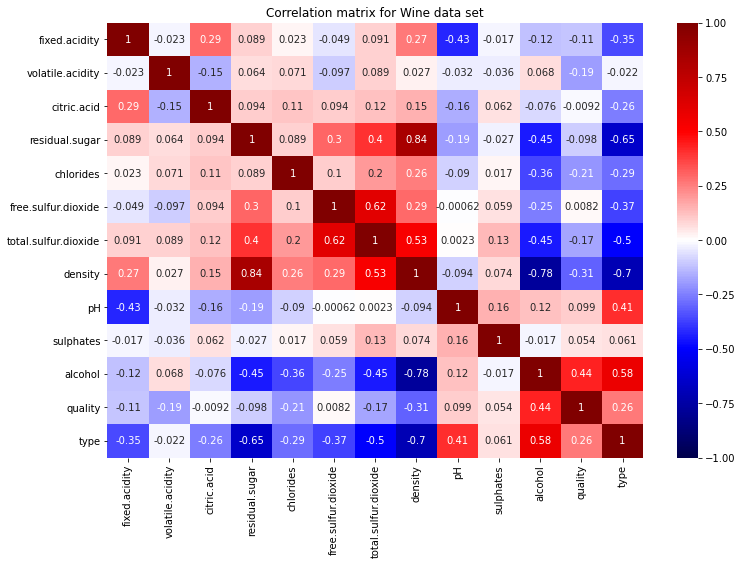

In [2]:
# Load the Wine data set
# You first need to upload this data set to the following path:
# '../input/wine-dataset/wine.csv'
wine = pd.read_csv('../input/wine-dataset/wine.csv', sep = ',')
dataset_size = len(wine)

# Fix the random seed
set_seed(seed = 60)

# Some initial analyses on Wine data set
print(wine.info()); display(wine.describe())
plt.figure(figsize = (12, 8))
sns.heatmap(wine.corr(), annot = True, cmap = 'seismic',
            vmin = -1, vmax = 1, center = 0)
plt.title('Correlation matrix for Wine data set')
display(wine[['quality']].join(pd.DataFrame({'count' : [1 for i in range(dataset_size)]})).\
    groupby('quality').count())

Visualize the Wine data set on 2-dimensional space using the Principal Component Analysis (PCA) technique

Text(0.5, 1.0, 'Visualization of Wine data set on 2-dimensional space')

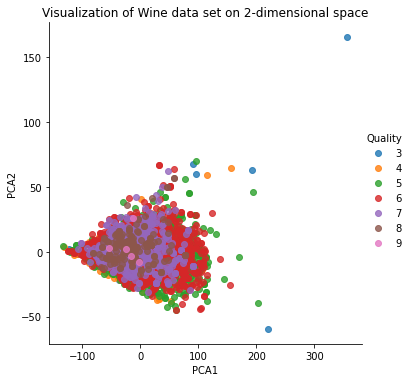

In [3]:
# In order to visualize the Wine data set, I use Principal Component Analysis
# (PCA) technique to reduce the dimension of the features of this data set.
model_dimredu = PCA(n_components = 2)
wine_features = wine.drop(['quality'], 1)
model_dimredu.fit(wine_features)
wine_features_2D = model_dimredu.transform(wine_features)

# I visualize the Wine data set on 2-dimensional space, with the
# data points classified by wine quality.
wine_dimredu = pd.concat(
    [pd.DataFrame(wine_features_2D, columns = ['PCA1', 'PCA2']),\
    wine[['quality']].rename(columns = {'quality' : 'Quality'})], axis = 1)
sns.lmplot(x = 'PCA1', y = 'PCA2', hue = 'Quality', data = wine_dimredu, fit_reg = False)
plt.title('Visualization of Wine data set on 2-dimensional space')

Prepare the data used to train the model and split them into train, validation and test set

In [4]:
# Prepare the data used to train the model
# Prepare the features and target of the Wine data set separately, convert the
# data set to "tensorflow.dataset" type and convert "wine quality" to "float" type
features = tf.constant(wine.drop(['quality'], 1))
labels = tf.constant(wine[['quality']])
wine_tfds = tf.data.Dataset.from_tensor_slices((features, labels)).\
    map(lambda x, y: (x, tf.cast(y, tf.float64))).\
    shuffle(buffer_size = dataset_size).prefetch(buffer_size = dataset_size)

# Split the data set into train, validation and test set, and batch each set
train_size = round(dataset_size*0.8)
validation_size = round(dataset_size*0.1)
test_size = dataset_size - train_size - validation_size
batch_size = 256
wine_train = wine_tfds.take(train_size).batch(batch_size)
wine_validation = wine_tfds.skip(train_size).take(validation_size).batch(validation_size)
wine_test = wine_tfds.skip(train_size + validation_size).batch(test_size)

Define the prior and variational posterior of network weight parameters and define the negative log-likelihood function of the model

In [5]:
# Define the prior weight distributions as independent standard normal distributions
def prior(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size
    return tkeras.Sequential([
        tfp.layers.DistributionLambda(
            lambda t: tfp.distributions.MultivariateNormalDiag(
                loc = tf.zeros(n), scale_diag = tf.ones(n))
        )
    ])

# Define the variational posterior weight distribution as multivariate Gaussian distribution
# The trainable parameters for this distribution are the means, variances, and covariances.
def posterior(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size
    return tkeras.Sequential([
               tfp.layers.VariableLayer(
                   tfp.layers.MultivariateNormalTriL.params_size(n), dtype = dtype
               ),
               tfp.layers.MultivariateNormalTriL(n),
           ])

# Define the negative log-likelihood function of the model
def negative_log_likelihood(y_true, y_pred):
    return -y_pred.log_prob(y_true)

Construct and train the Bayesian neural network (BNN) model

In [6]:
# Specify some model parameters
kl_loss_weight = 1/train_size
learning_rate = 0.001
num_epochs = 1000

# Construct the Bayesian neural network model with two hidden layers
wine_model = tkeras.Sequential([
    tkeras.layers.Input(shape = (12,)),
    tkeras.layers.BatchNormalization(),
    tfp.layers.DenseVariational(
        units = 8, make_posterior_fn = posterior,
        make_prior_fn = prior, kl_weight = kl_loss_weight,
        activation = 'sigmoid'
    ),
    tfp.layers.DenseVariational(
        units = 8, make_posterior_fn = posterior,
        make_prior_fn = prior, kl_weight = kl_loss_weight,
        activation = 'sigmoid'
    ),
    tkeras.layers.Dense(units = 2),
    tfp.layers.IndependentNormal(1)
])

# View the structure of the model
wine_model.summary()

# Compile the constructed Bayesian neural network
# We take the negative Evidence Lower Bound (-ELBO) as the loss function,
# and use the RMSprop optimizer with learning rate being equal to 0.001 to
# minimize the loss function, and use Mean Square Error (MSE) as the metric
# to evaluate the accuracy of the model.
wine_model.compile(
    optimizer = tkeras.optimizers.RMSprop(learning_rate = learning_rate),
    loss = negative_log_likelihood,
    metrics = [tkeras.metrics.mean_squared_error]
)

# Fit the constructed Bayesian neural network with data
wine_fit = wine_model.fit(x = wine_train, epochs = num_epochs,
                          validation_data = wine_validation)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 12)                48        
_________________________________________________________________
dense_variational (DenseVari (None, 8)                 5564      
_________________________________________________________________
dense_variational_1 (DenseVa (None, 8)                 2700      
_________________________________________________________________
dense (Dense)                (None, 2)                 18        
_________________________________________________________________
independent_normal (Independ multiple                  0         
Total params: 8,330
Trainable params: 8,306
Non-trainable params: 24
_________________________________________________________________
Epoch 1/1000
16/16 [==============================] - 4s 74ms/step - loss: 23.1284 - mean_squared_error: 42.2799 - val_

Draw the trend of the loss and the MSE on the train and validation set during the training process respectively

[1.1512471437454224, 1.1381399631500244]
[1.1099435091018677, 1.0951550006866455]


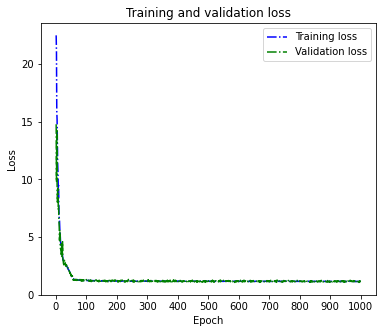

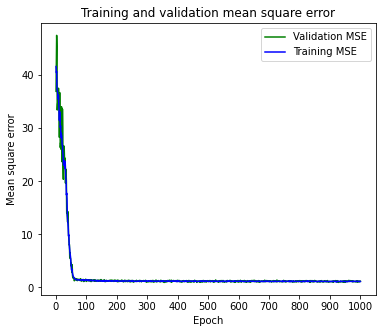

In [7]:
# Draw the trend of the loss and the MSE on the train and
# validation set during the training process respectively

# Prepare the data
train_loss = wine_fit.history['loss']
val_loss = wine_fit.history['val_loss']
train_eva = wine_fit.history['mean_squared_error']
val_eva = wine_fit.history['val_mean_squared_error']
epochs = range(1, num_epochs + 1)

# The trend of loss on the train and validation set
fig1 = plt.figure(figsize = (6, 5)); ax1 = plt.axes()
ax1.plot(epochs, train_loss, 'b-.', label = 'Training loss')
ax1.plot(epochs, val_loss, 'g-.', label = 'Validation loss')
ax1.xaxis.set_major_locator(plt.MultipleLocator(100))
ax1.set(xlabel = 'Epoch', ylabel = 'Loss',
        title = 'Training and validation loss')
ax1.legend()

# The trend of the metric (MSE) on the train and validation set
fig2 = plt.figure(figsize = (6, 5)); ax2 = plt.axes()
ax2.plot(epochs, val_eva, 'g-', label = 'Validation MSE')
ax2.plot(epochs, train_eva, 'b-', label = 'Training MSE')
ax2.xaxis.set_major_locator(plt.MultipleLocator(100))
ax2.set(xlabel = 'Epoch', ylabel = 'Mean square error',
        title = 'Training and validation mean square error')
ax2.legend()

# Evaluate the trained model on both train set and test set respectively
print(wine_model.evaluate(wine_train, verbose = 0))
print(wine_model.evaluate(wine_test, verbose = 0))

I take 12 samples from the test set, two samples per quality level (from 3 to 8). Then, I construct and visualize the 95% confidence intervals for the predictions of these selected samples.

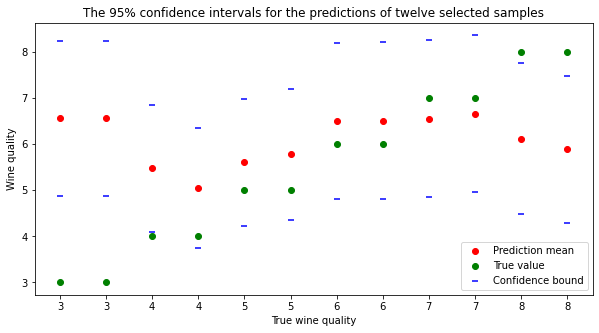

In [8]:
# Take 12 samples from the test set, two samples per quality level (from 3 to 8)
features_exa, targets_exa = list(wine_test)[0]
features_exa = features_exa.numpy()
targets_exa = targets_exa.numpy()[:, 0]
sample_ind = np.array([])
for k in range(3, 9):
    choice = np.random.choice(np.where(targets_exa == k)[0], size = 2)
    sample_ind = np.concatenate([sample_ind, choice])
examples = features_exa[sample_ind.astype('int'), :]
labels_exa = targets_exa[sample_ind.astype('int')]

# Compare the prediction means with the true labels
examples_mean = wine_model(examples).mean().numpy()
examples_std = wine_model(examples).stddev().numpy()

# Construct and visualize the 95% confidence intervals for the predictions
plt.figure(figsize = (10, 5))
index = range(1, 13)
quality = np.concatenate(np.array([[k, k] for k in range(3, 9)]))
plt.scatter(index, examples_mean, color = 'red', label = 'Prediction mean')
plt.scatter(index, labels_exa, color = 'green', label = 'True value')
plt.scatter(index, examples_mean + 1.96*examples_std,
            color = 'blue', marker = '_', label = 'Confidence bound')
plt.scatter(index, examples_mean - 1.96*examples_std,
            color = 'blue', marker = '_')
plt.xlabel('True wine quality'); plt.ylabel('Wine quality')
plt.xticks(ticks = index, labels = quality)
plt.title('The 95% confidence intervals for the predictions of twelve selected samples')
plt.legend()

Clear the model and re-train the model with the whole data set

In [9]:
# Clear the model and re-train the model with the whole data set

# Update the weight for the KL divergence loss between
# the surrogate posterior and weight prior
kl_loss_weight = 1/dataset_size

# Clear the model
wine_model = tkeras.Sequential([
    tkeras.layers.Input(shape = (12,)),
    tkeras.layers.BatchNormalization(),
    tfp.layers.DenseVariational(
        units = 8, make_posterior_fn = posterior,
        make_prior_fn = prior, kl_weight = kl_loss_weight,
        activation = 'sigmoid'
    ),
    tfp.layers.DenseVariational(
        units = 8, make_posterior_fn = posterior,
        make_prior_fn = prior, kl_weight = kl_loss_weight,
        activation = 'sigmoid'
    ),
    tkeras.layers.Dense(units = 2),
    tfp.layers.IndependentNormal(1)
])

# Re-compile the model with the same settings
wine_model.compile(
    optimizer = tkeras.optimizers.RMSprop(learning_rate = learning_rate),
    loss = negative_log_likelihood,
    metrics = [tkeras.metrics.mean_squared_error]
)

# Re-fit the model with the whole data set
wine_model.fit(x = wine_tfds.batch(batch_size), epochs = num_epochs)

Epoch 1/1000
20/20 [==============================] - 2s 4ms/step - loss: 15.5380 - mean_squared_error: 29.1109
Epoch 2/1000
20/20 [==============================] - 0s 4ms/step - loss: 12.0624 - mean_squared_error: 29.6800
Epoch 3/1000
20/20 [==============================] - 0s 4ms/step - loss: 10.4928 - mean_squared_error: 28.3960
Epoch 4/1000
20/20 [==============================] - 0s 4ms/step - loss: 7.9601 - mean_squared_error: 26.5398
Epoch 5/1000
20/20 [==============================] - 0s 4ms/step - loss: 7.3273 - mean_squared_error: 25.3864
Epoch 6/1000
20/20 [==============================] - 0s 4ms/step - loss: 6.0359 - mean_squared_error: 24.9611
Epoch 7/1000
20/20 [==============================] - 0s 4ms/step - loss: 5.6789 - mean_squared_error: 24.6309
Epoch 8/1000
20/20 [==============================] - 0s 4ms/step - loss: 4.1650 - mean_squared_error: 22.3156
Epoch 9/1000
20/20 [==============================] - 0s 4ms/step - loss: 4.2419 - mean_squared_error: 21.866

Quantify and plot all kinds of uncertainties of the predictions

0.04062882809309922
199


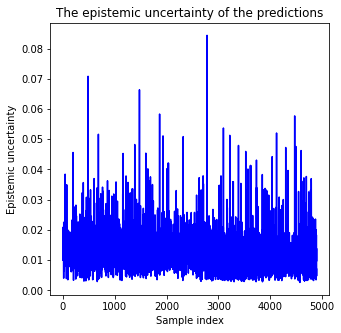

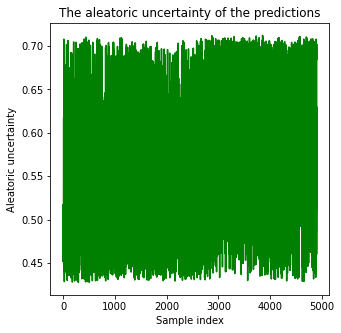

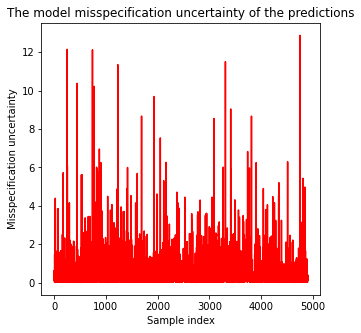

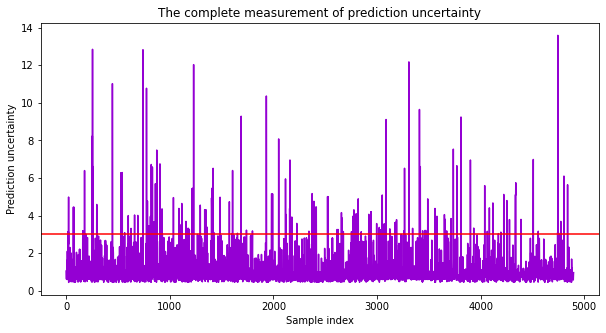

In [10]:
# Quantify all kinds of uncertainties of the predictions
N = 1000; records = np.zeros((N, dataset_size, 3))
for i in range(N):
    records[i, :, 0] = wine_model(features).mean().numpy()[:, 0]
    records[i, :, 1] = wine_model(features).variance().numpy()[:, 0]
    records[i, :, 2] = ((wine_model(features).mean().numpy() - labels.numpy())**2)[:, 0]
epistemic = np.var(records[:, :, 0], axis = 0)
aleatoric = np.mean(records[:, :, 1], axis = 0)
misspecification = np.mean(records[:, :, 2], axis = 0)
P = 1; Q = 1; R = 1
comp_uncer = P*epistemic + Q*aleatoric + R*misspecification

# Plot all kinds of uncertainties
X = range(1, dataset_size + 1)

# Plot the epistemic uncertainty
plt.figure(figsize = (5, 5))
plt.plot(X, epistemic, 'b-')
plt.xlabel('Sample index')
plt.ylabel('Epistemic uncertainty')
plt.title('The epistemic uncertainty of the predictions')

# Plot the aleatoric uncertainty
plt.figure(figsize = (5, 5))
plt.plot(X, aleatoric, 'g-')
plt.xlabel('Sample index')
plt.ylabel('Aleatoric uncertainty')
plt.title('The aleatoric uncertainty of the predictions')

# Plot the model misspecification uncertainty
plt.figure(figsize = (5, 5))
plt.plot(X, misspecification, 'r-')
plt.xlabel('Sample index')
plt.ylabel('Misspecification uncertainty')
plt.title('The model misspecification uncertainty of the predictions')

# Plot the total prediction uncertainty
plt.figure(figsize = (10, 5))
plt.plot(X, comp_uncer, color = 'darkviolet')
plt.xlabel('Sample index')
plt.ylabel('Prediction uncertainty')
plt.title('The complete measurement of prediction uncertainty')
threshold = 3
plt.axhline(threshold, color = 'red')

# Record the information about the index of outliers
index = (comp_uncer > threshold).astype('int').tolist()
wine_BNN = wine_dimredu.join(pd.DataFrame(index, columns = ['indicator'])).\
                        join(pd.DataFrame(comp_uncer, columns = ['uncertainty']))
print(np.mean(index)); print(np.sum(index))

Perform the Local Outlier Factor (LOF) method and DBSCAN method on Wine data set

In [11]:
# Perform the Local Outlier Factor (LOF) method on Wine data set
Lof = LocalOutlierFactor()
Lof_pre = Lof.fit_predict(wine)
Lof_fac = Lof.negative_outlier_factor_
wine_LOF = wine_dimredu.join(pd.DataFrame(Lof_pre, columns = ['indicator'])).\
                        join(pd.DataFrame(Lof_fac, columns = ['factor']))

# Perform the DBSCAN method on Wine data set
DBSCAN_model = DBSCAN(eps = 8, min_samples = 5)
DBSCAN_fit = DBSCAN_model.fit(wine)
DBSCAN_pre = DBSCAN_fit.labels_
DBSCAN_noise = (DBSCAN_pre == -1).astype('int')
wine_DBSCAN = wine_dimredu.join(pd.DataFrame(DBSCAN_noise, columns = ['indicator']))

Visualize the results of outlier detection using BNN, LOF and DBSCAN method respectively

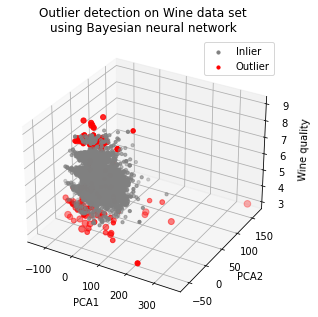

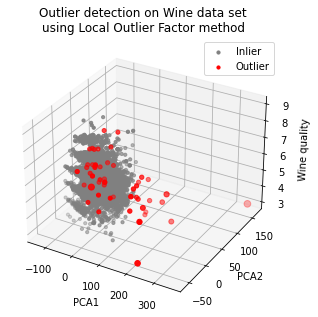

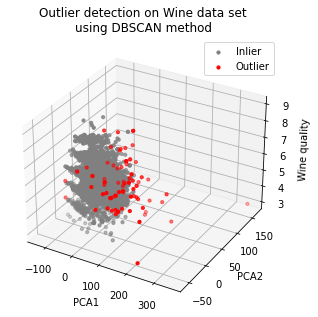

In [12]:
# Visualize the effects of the three outlier detection methods on Wine data set

# The visualization of the effect of Bayesian neural network
plt.figure(figsize = (5, 5))
ax1 = plt.axes(projection = '3d')
uncer_outlier = wine_BNN['uncertainty'][wine_BNN['indicator'] == 1]
ax1.scatter3D(wine_BNN['PCA1'][wine_BNN['indicator'] == 0],
              wine_BNN['PCA2'][wine_BNN['indicator'] == 0],
              wine_BNN['Quality'][wine_BNN['indicator'] == 0],
              c = 'gray', s = 10, label = 'Inlier')
ax1.scatter3D(wine_BNN['PCA1'][wine_BNN['indicator'] == 1],
              wine_BNN['PCA2'][wine_BNN['indicator'] == 1],
              wine_BNN['Quality'][wine_BNN['indicator'] == 1],
              c = 'red', s = 10 + 2.5*uncer_outlier)
ax1.scatter3D([], [], [], c = 'red', s = 10, label = 'Outlier')
ax1.set(xlabel = 'PCA1', ylabel = 'PCA2', zlabel = 'Wine quality',
        title = 'Outlier detection on Wine data set\nusing Bayesian neural network')
plt.legend()

# The visualization of the effect of Local Outlier Factor method
plt.figure(figsize = (5, 5))
ax2 = plt.axes(projection = '3d')
ax2.scatter3D(wine_LOF['PCA1'][wine_LOF['indicator'] == 1],
              wine_LOF['PCA2'][wine_LOF['indicator'] == 1],
              wine_LOF['Quality'][wine_LOF['indicator'] == 1],
              c = 'gray', s = 10, label = 'Inlier')
LOF_outlier = wine_LOF['factor'][wine_LOF['indicator'] == -1]
ax2.scatter3D(wine_LOF['PCA1'][wine_LOF['indicator'] == -1],
              wine_LOF['PCA2'][wine_LOF['indicator'] == -1],
              wine_LOF['Quality'][wine_LOF['indicator'] == -1],
              c = 'red', s = 10 - 4*LOF_outlier)
ax2.scatter3D([], [], [], c = 'red', s = 10, label = 'Outlier')
ax2.set(xlabel = 'PCA1', ylabel = 'PCA2', zlabel = 'Wine quality',
        title = 'Outlier detection on Wine data set\nusing Local Outlier Factor method')
plt.legend()

# The visualization of the effect of DBSCAN method
plt.figure(figsize = (5, 5))
ax3 = plt.axes(projection = '3d')
ax3.scatter3D(wine_DBSCAN['PCA1'][wine_DBSCAN['indicator'] == 0],
              wine_DBSCAN['PCA2'][wine_DBSCAN['indicator'] == 0],
              wine_DBSCAN['Quality'][wine_DBSCAN['indicator'] == 0],
              c = 'gray', s = 10, label = 'Inlier')
ax3.scatter3D(wine_DBSCAN['PCA1'][wine_DBSCAN['indicator'] == 1],
              wine_DBSCAN['PCA2'][wine_DBSCAN['indicator'] == 1],
              wine_DBSCAN['Quality'][wine_DBSCAN['indicator'] == 1],
              c = 'red', s = 10, label = 'Outlier')
ax3.set(xlabel = 'PCA1', ylabel = 'PCA2', zlabel = 'Wine quality',
        title = 'Outlier detection on Wine data set\nusing DBSCAN method')
plt.legend()

## Part 2 - The exploration on the MNIST data set

Load the MNIST data set  
You first need to upload this data set to the following path on Kaggle:  
**'../input/mnist-dataset/mnist.csv'**  

Perform some initial analyses on MNIST data set

In [13]:
# Load the MNIST data set and adjust the column name
# You first need to upload this data set to the following path:
# '../input/mnist-dataset/mnist.csv'
mnist = pd.read_csv('../input/mnist-dataset/mnist.csv', sep = ',')
mnist.rename(columns = {'Unnamed: 0' : 'index_ori'}, inplace = True)
mnist_data = mnist.drop(['index_ori'], 1)

# Fix the random seed
set_seed(seed = 200)

# Some initial analyses on the MNIST data set
dataset_size = len(mnist)
print(mnist.info()); display(mnist.describe())
display(mnist[['label']].join(pd.DataFrame({'count' : [1 for i in range(dataset_size)]})).\
    groupby('label').count())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17280 entries, 0 to 17279
Columns: 786 entries, index_ori to pixel783
dtypes: float64(784), int64(2)
memory usage: 103.6 MB
None


,index_ori,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,17280.000000,17280.000000,17280.0,17280.0,17280.0,17280.0,17280.0,17280.0,17280.0,17280.0,...,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.0,17280.0,17280.0,17280.0
mean,21083.968113,3.934896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001844,0.000938,0.000397,0.000086,0.000118,0.000027,0.0,0.0,0.0,0.0
std,12125.338906,3.509446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.035979,0.025972,0.016428,0.006243,0.010527,0.002533,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,10597.750000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,21117.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,31644.000000,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,41997.000000,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.996078,0.996078,0.992157,0.694118,0.996078,0.243137,0.0,0.0,0.0,0.0


,count
label,
0,4132
1,4684
7,4401
8,4063


I randomly take 50 samples from MNIST data set and visualize these digits.

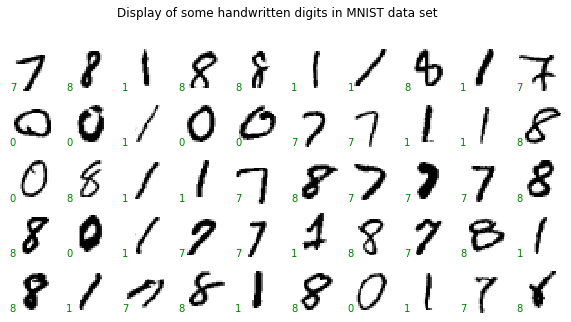

In [14]:
# Randomly take some samples from MNIST data set and visualize these digits
n_examples = 50
examples = np.random.permutation(mnist)[:n_examples, :]
features_exa = examples[:, 2:].reshape(n_examples, 28, 28)
labels_exa = examples[:, 1].astype('int')

columns = 10; rows = int(n_examples/columns)
figs, axes = plt.subplots(rows, columns, figsize = (columns, rows),
                          subplot_kw = {'xticks':[], 'yticks':[]},
                          gridspec_kw = dict(hspace = 0.1, wspace = 0.1))
plt.suptitle('Display of some handwritten digits in MNIST data set')
for i, ax in enumerate(axes.flat):
    ax.imshow(features_exa[i], cmap = 'binary', interpolation = 'nearest')
    ax.text(0.05, 0.05, str(labels_exa[i]), transform = ax.transAxes, color = 'green')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

Prepare the data used to train the model and split them into train, validation and test set

In [15]:
# Prepare the data used to train the model
# Prepare the features and target of MNIST data set separately, and
# convert the data set to "tensorflow.dataset" type
mnist_onehot = OneHotEncoder()
mnist_onehot.fit(mnist_data[['label']].values)
labels = mnist_onehot.transform(mnist_data[['label']].values).A
features = tf.constant(mnist_data.loc[:, 'pixel0':'pixel783'].\
                       values.reshape(dataset_size, 28, 28, 1))
labels = tf.constant(labels)
mnist_tfds = tf.data.Dataset.from_tensor_slices((features, labels)).\
    shuffle(buffer_size = dataset_size).prefetch(buffer_size = dataset_size)

# Split the data set into train, validation and test set
train_size = round(dataset_size*0.85)
validation_size = round(dataset_size*0.075)
test_size = dataset_size - train_size - validation_size
mnist_train = mnist_tfds.take(train_size).batch(train_size)
mnist_validation = mnist_tfds.skip(train_size).take(validation_size).batch(validation_size)
mnist_test = mnist_tfds.skip(train_size + validation_size).batch(test_size)

Construct and train the Bayesian convolutional neural network (BCNN) model

In [16]:
# Specify some model parameters
learning_rate = 0.002
num_epochs = 2000

# Define the loss function
# We still use the negative Evidence Lower Bound as the loss function
def negative_ELBO(label_true, label_pred):
    neg_log_likelihood = -tf.reduce_sum(label_pred.log_prob(label_true))
    kl = sum(mnist_model.losses)
    return neg_log_likelihood + kl/train_size

# Construct the Bayesian convolutional neural network model
mnist_model = tkeras.Sequential([
    tkeras.layers.Input(shape = (28, 28, 1)),
    tfp.layers.Convolution2DFlipout(filters = 4, kernel_size = (5, 5),
                                    padding = "SAME", activation = 'relu'),
    tkeras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),
    tfp.layers.Convolution2DFlipout(filters = 8, kernel_size = (5, 5),
                                    padding = "SAME", activation = 'relu'),
    tkeras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),
    tfp.layers.Convolution2DFlipout(filters = 16, kernel_size = (5, 5),
                                    padding = "SAME", activation = 'relu'),
    tkeras.layers.Flatten(),
    tkeras.layers.Dropout(0.5),
    tfp.layers.DenseFlipout(units = 8, activation = 'relu'),
    tkeras.layers.Dense(units = 4, activation = 'softmax'),
    tfp.layers.OneHotCategorical(event_size = 4,
                                 convert_to_tensor_fn = tfp.distributions.Distribution.mode)
])

# View the structure of the model
mnist_model.summary()

# Compile the constructed Bayesian convolutional neural network
# I use the Adam optimizer with learning rate being equal to 0.002 to minimize the
# loss function, and use the classification accuracy to evaluate the model accuracy.
mnist_model.compile(
    optimizer = tkeras.optimizers.Adam(learning_rate = learning_rate),
    loss = negative_ELBO,
    metrics = [tkeras.metrics.categorical_accuracy]
)

# Fit the constructed Bayesian convolutional neural network with data
mnist_fit = mnist_model.fit(x = mnist_train, epochs = num_epochs,
                            validation_data = mnist_validation)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 28, 28, 4)         204       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 4)         0         
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 14, 14, 8)         1608      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_flipout_2 (Conv2DFlip (None, 7, 7, 16)          6416      
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dropout (Dropout)            (None, 784)              

Draw the trend of the loss and the MSE on the train and validation set during the training process respectively

[13726.0498046875, 0.9863153696060181]
[3587.12841796875, 0.9845678806304932]


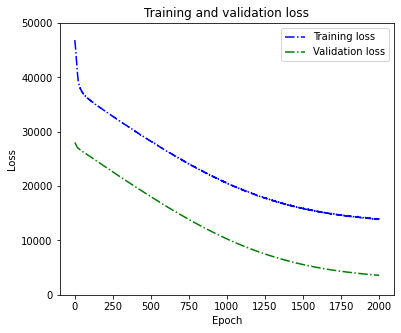

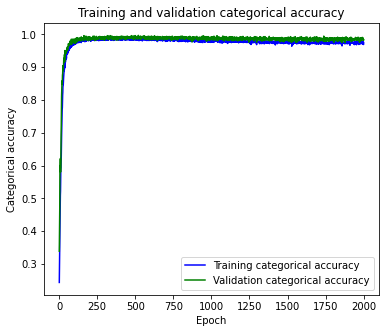

In [17]:
# Draw the trend of the loss and the classification accuracy on the
# train and validation set during the training process respectively

# Prepare the data
train_loss = mnist_fit.history['loss']
val_loss = mnist_fit.history['val_loss']
train_eva = mnist_fit.history['categorical_accuracy']
val_eva = mnist_fit.history['val_categorical_accuracy']
epochs = range(1, num_epochs + 1)

# The trend of loss on the train and validation set
fig1 = plt.figure(figsize = (6, 5)); ax1 = plt.axes()
ax1.plot(epochs, train_loss, 'b-.', label = 'Training loss')
ax1.plot(epochs, val_loss, 'g-.', label = 'Validation loss')
ax1.xaxis.set_major_locator(plt.MultipleLocator(250))
ax1.set(xlabel = 'Epoch', ylabel = 'Loss', ylim = (0, 50000),
        title = 'Training and validation loss')
ax1.legend()

# The trend of classification accuracy on the train and validation set
fig2 = plt.figure(figsize = (6, 5)); ax2 = plt.axes()
ax2.plot(epochs, train_eva, 'b-', label = 'Training categorical accuracy')
ax2.plot(epochs, val_eva, 'g-', label = 'Validation categorical accuracy')
ax2.xaxis.set_major_locator(plt.MultipleLocator(250))
ax2.set(xlabel = 'Epoch', ylabel = 'Categorical accuracy',
        title = 'Training and validation categorical accuracy')
ax2.legend()

# Evaluate the trained model on both train set and test set respectively
print(mnist_model.evaluate(mnist_train, verbose = 0))
print(mnist_model.evaluate(mnist_test, verbose = 0))

Clear the model and re-train the model with the whole data set

In [18]:
# Clear the model and re-train the model with the whole data set

# Re-define the loss function in order to update the weight for the
# KL divergence loss between the surrogate posterior and weight prior
def negative_ELBO(label_true, label_pred):
    neg_log_likelihood = -tf.reduce_sum(label_pred.log_prob(label_true))
    kl = sum(mnist_model.losses)
    return neg_log_likelihood + kl/dataset_size

# Clear the model
mnist_model = tkeras.Sequential([
    tkeras.layers.Input(shape = (28, 28, 1)),
    tfp.layers.Convolution2DFlipout(filters = 4, kernel_size = (5, 5),
                                    padding = "SAME", activation = 'relu'),
    tkeras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),
    tfp.layers.Convolution2DFlipout(filters = 8, kernel_size = (5, 5),
                                    padding = "SAME", activation = 'relu'),
    tkeras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),
    tfp.layers.Convolution2DFlipout(filters = 16, kernel_size = (5, 5),
                                    padding = "SAME", activation = 'relu'),
    tkeras.layers.Flatten(),
    tkeras.layers.Dropout(0.5),
    tfp.layers.DenseFlipout(units = 8, activation = 'relu'),
    tkeras.layers.Dense(units = 4, activation = 'softmax'),
    tfp.layers.OneHotCategorical(event_size = 4,
                                 convert_to_tensor_fn = tfp.distributions.Distribution.mode)
])

# Re-compile the model with the same settings
mnist_model.compile(
    optimizer = tkeras.optimizers.Adam(learning_rate = learning_rate),
    loss = negative_ELBO,
    metrics = [tkeras.metrics.categorical_accuracy]
)

# Re-fit the model with the whole data set
mnist_model.fit(x = mnist_tfds.batch(dataset_size), epochs = num_epochs)

Epoch 1/2000
1/1 [==============================] - 3s 3s/step - loss: 50387.9922 - categorical_accuracy: 0.2268
Epoch 2/2000
1/1 [==============================] - 0s 381ms/step - loss: 50125.1250 - categorical_accuracy: 0.2538
Epoch 3/2000
1/1 [==============================] - 0s 335ms/step - loss: 49922.0078 - categorical_accuracy: 0.2939
Epoch 4/2000
1/1 [==============================] - 0s 395ms/step - loss: 49776.5391 - categorical_accuracy: 0.3183
Epoch 5/2000
1/1 [==============================] - 0s 335ms/step - loss: 49579.3242 - categorical_accuracy: 0.3554
Epoch 6/2000
1/1 [==============================] - 0s 332ms/step - loss: 49415.4766 - categorical_accuracy: 0.3697
Epoch 7/2000
1/1 [==============================] - 0s 386ms/step - loss: 49097.2773 - categorical_accuracy: 0.4023
Epoch 8/2000
1/1 [==============================] - 0s 387ms/step - loss: 48778.7227 - categorical_accuracy: 0.4232
Epoch 9/2000
1/1 [==============================] - 0s 340ms/step - loss: 4

Quantify and plot all kinds of uncertainties of the predictions

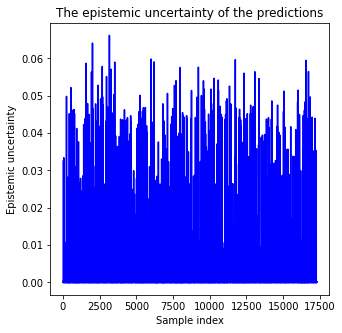

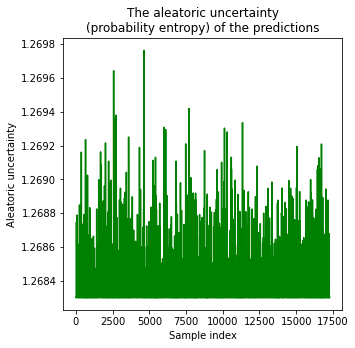

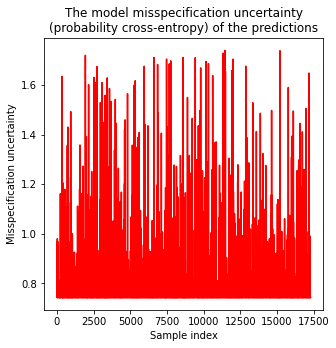

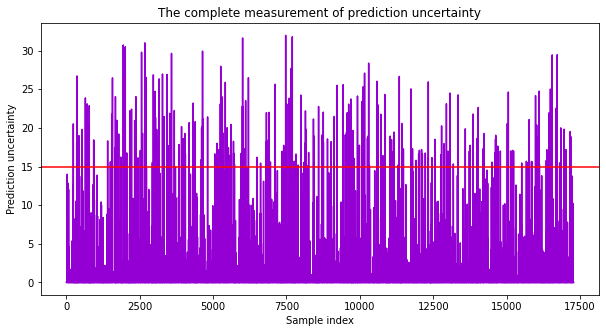

In [19]:
# Quantify all kinds of uncertainties of the predictions
N = 1000; records = np.zeros((N, dataset_size, 6))
for i in range(N):
    records[i, :, 0:4] = mnist_model(features).mean().numpy()
    records[i, :, 4] = mnist_model(features).entropy().numpy()
    records[i, :, 5] = -np.sum(np.log(mnist_model(features).mean().numpy())*\
                               labels.numpy(), axis = 1)
epistemic = 0
for i in range(4):
    epistemic += np.var(records[:, :, i], axis = 0)
aleatoric = np.mean(records[:, :, 4], axis = 0)
misspecification = np.mean(records[:, :, 5], axis = 0)
P = 1/np.std(epistemic); Q = 1/np.std(aleatoric); R = 1/np.std(misspecification);
W = -(P*np.min(epistemic) + Q*np.min(aleatoric) + R*np.min(misspecification))
comp_uncer = P*epistemic + Q*aleatoric + R*misspecification + W

# Plot all kinds of uncertainties
X = range(1, dataset_size + 1)

# Plot the epistemic uncertainty
plt.figure(figsize = (5, 5))
plt.plot(X, epistemic, 'b-')
plt.xlabel('Sample index')
plt.ylabel('Epistemic uncertainty')
plt.title('The epistemic uncertainty of the predictions')

# Plot the aleatoric uncertainty (entropy of the probability vector)
plt.figure(figsize = (5, 5))
plt.plot(X, aleatoric, 'g-')
plt.xlabel('Sample index')
plt.ylabel('Aleatoric uncertainty')
plt.title('The aleatoric uncertainty\n(probability entropy) of the predictions')

# Plot the model misspecification uncertainty (cross-entropy of the probability vector)
plt.figure(figsize = (5, 5))
plt.plot(X, misspecification, 'r-')
plt.xlabel('Sample index')
plt.ylabel('Misspecification uncertainty')
plt.title('The model misspecification uncertainty\n(probability' +
          ' cross-entropy) of the predictions')

# Plot the total prediction uncertainty
plt.figure(figsize = (10, 5))
plt.plot(X, comp_uncer, color = 'darkviolet')
plt.xlabel('Sample index')
plt.ylabel('Prediction uncertainty')
plt.title('The complete measurement of prediction uncertainty')
threshold = 15
plt.axhline(threshold, color = 'red')

Visualize the result of outlier detection on MNIST data set using BCNN

0.014293981481481482
247


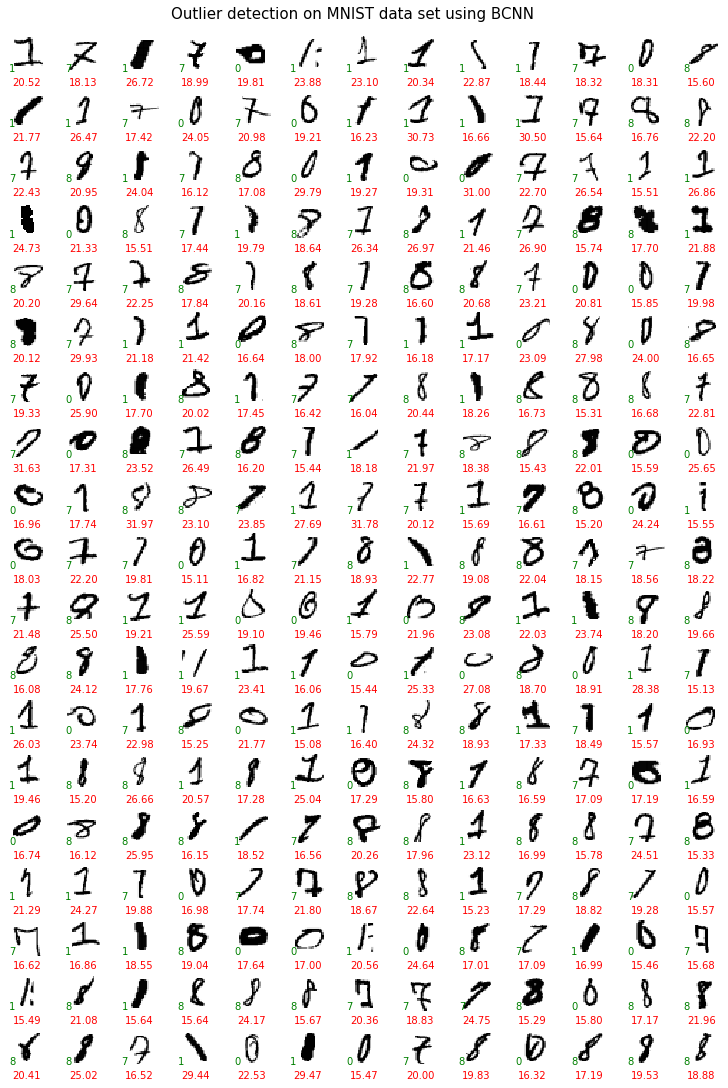

In [20]:
# Record the information about the index of outliers
location = (comp_uncer > threshold)
index = np.where(location)[0]
n_outliers = len(index)
print(np.mean(location)); print(n_outliers)

# Visualize the result of outlier detection on MNIST data set using BCNN
columns = 13; rows = int(n_outliers/columns) + 1 \
    if n_outliers%columns != 0 else int(n_outliers/columns)
figs, axes = plt.subplots(rows, columns, figsize = (columns, rows),
                          subplot_kw = {'xticks':[], 'yticks':[]},
                          gridspec_kw = dict(hspace = 0.4, wspace = 0.1))
plt.suptitle('Outlier detection on MNIST data set using BCNN',
             y = 0.9, fontsize = 15)
for i, ax in enumerate(axes.flat):
    if i < n_outliers:
        ax.imshow(features.numpy()[index[i]], cmap = 'binary', interpolation = 'nearest')
        ax.text(0.05, 0.05, str(int(mnist_data[['label']].values[index[i]])),
                transform = ax.transAxes, color = 'green')
        ax.set_xlabel('{:.2f}'.format(comp_uncer[index[i]]), color = 'red')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
    else:
        ax.axis('off')

Perform outlier detection on MNIST data set using LOF and DBSCAN method respectively, and visualize the results of these two methods

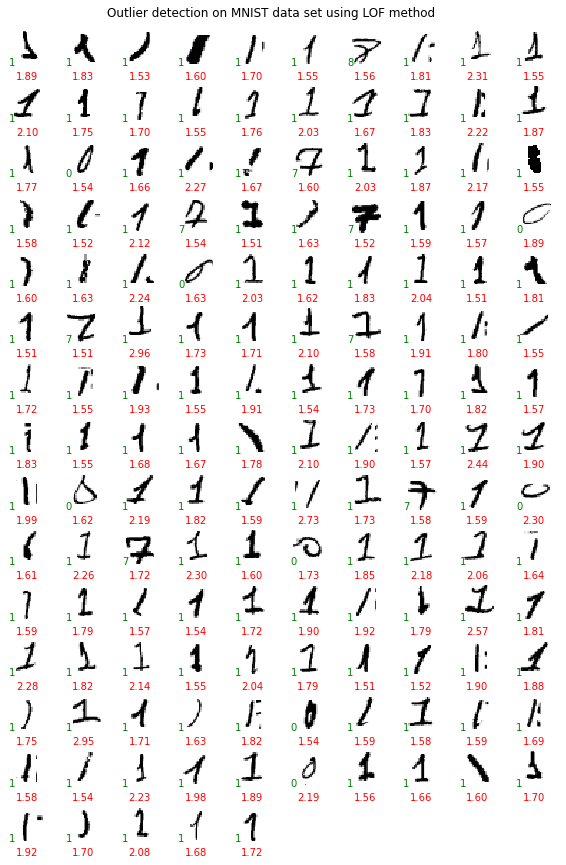

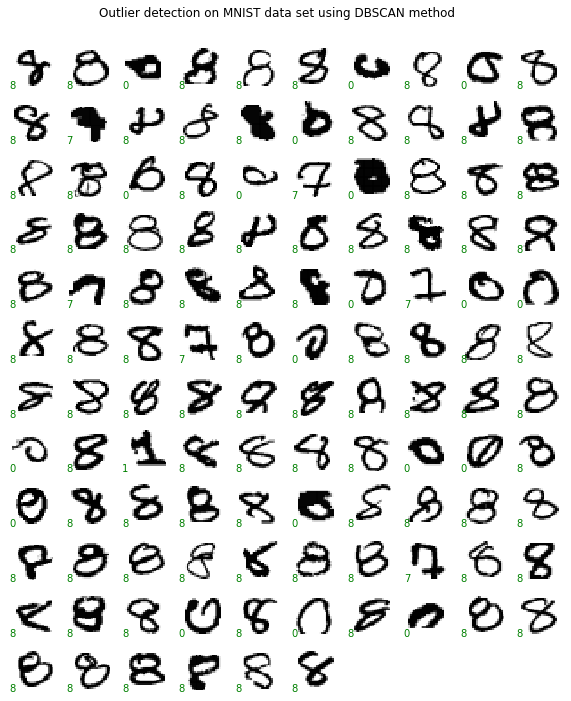

In [38]:
# Outlier detection on MNIST data set using Local Outlier Factor method
Lof = LocalOutlierFactor(); offset = -1.5
Lof.fit(mnist_data)
Lof_fac = Lof.negative_outlier_factor_
Lof_pre = (Lof_fac < offset).astype('int')
index_out = (Lof_pre == 1)
n_outliers = sum(index_out)
outliers_feature = mnist_data[index_out].drop('label', 1).\
                   values.reshape(n_outliers, 28, 28)
outliers_label = mnist_data[index_out]['label'].values

# Visualize the result of outlier detection on MNIST data set using LOF method
columns = 10; rows = int(n_outliers/columns) + 1 \
    if n_outliers%columns != 0 else int(n_outliers/columns)
figs, axes = plt.subplots(rows, columns, figsize = (columns, rows),
                          subplot_kw = {'xticks':[], 'yticks':[]},
                          gridspec_kw = dict(hspace = 0.4, wspace = 0.1))
plt.suptitle('Outlier detection on MNIST data set using LOF method', y = 0.9)
for i, ax in enumerate(axes.flat):
    if i < n_outliers:
        ax.imshow(outliers_feature[i], cmap = 'binary', interpolation = 'nearest')
        ax.text(0.05, 0.05, str(outliers_label[i]),
                transform = ax.transAxes, color = 'green')
        ax.set_xlabel('{:.2f}'.format(-Lof_fac[np.where(index_out)[0][i]]), color = 'red')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
    else:
        ax.axis('off')

# Outlier detection on MNIST data set using DBSCAN method
DBSCAN_model = DBSCAN(eps = 7.2, min_samples = 5)
DBSCAN_fit = DBSCAN_model.fit(mnist_data)
DBSCAN_pre = DBSCAN_fit.labels_
index_noise = (DBSCAN_pre == -1); n_noise = sum(index_noise)
noise_feature = mnist_data[index_noise].drop('label', 1).\
                values.reshape(n_noise, 28, 28)
noise_label = mnist_data[index_noise]['label'].values

# Visualize the result of outlier detection on MNIST data set using DBSCAN method
columns = 10; rows = int(n_noise/columns) + 1 \
    if n_noise%columns != 0 else int(n_noise/columns)
figs, axes = plt.subplots(rows, columns, figsize = (columns, rows),
                          subplot_kw = {'xticks':[], 'yticks':[]},
                          gridspec_kw = dict(hspace = 0.1, wspace = 0.1))
plt.suptitle('Outlier detection on MNIST data set using DBSCAN method', y = 0.92)
for i, ax in enumerate(axes.flat):
    if i < n_noise:
        ax.imshow(noise_feature[i], cmap = 'binary', interpolation = 'nearest')
        ax.text(0.05, 0.05, str(noise_label[i]),
                transform = ax.transAxes, color = 'green')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
    else:
        ax.axis('off')

## Part 3 - The exploration on the Taxi data set

Load the Taxi data set  
You first need to upload this data set to the following path on Kaggle:  
**'../input/taxi-dataset/taxi.csv'**  

Perform some initial analyses on Taxi data set and remove the seasonal variation of Taxi data set

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10320 entries, 2014-07-01 00:00:00 to 2015-01-31 23:30:00
Freq: 30T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   10320 non-null  int64
dtypes: int64(1)
memory usage: 161.2 KB
None


,value
count,10320.000000
mean,15137.569380
std,6939.495808
min,8.000000
25%,10262.000000
50%,16778.000000
75%,19838.750000
max,39197.000000


Text(0.5, 1.0, 'Counts of taxi passengers in New-York city after removing seasonal variation')

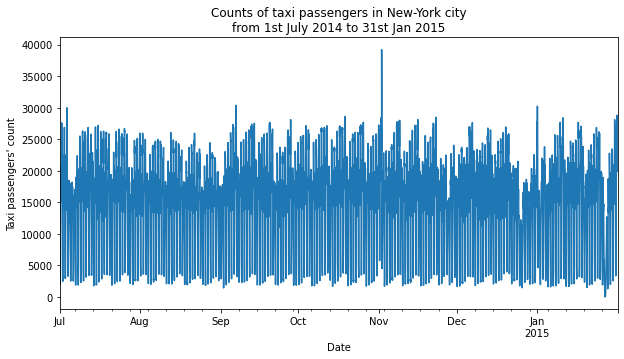

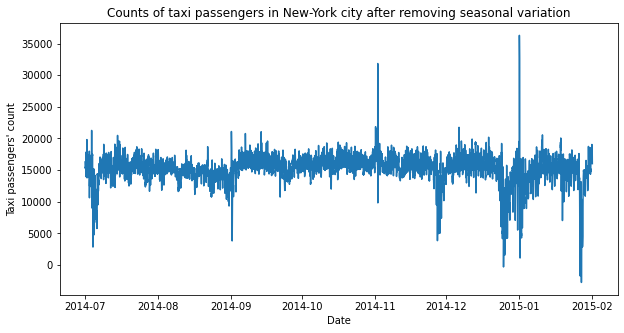

In [43]:
# Load the Taxi data set and use the 'timestamp' column as index
# You first need to upload this data set to the following path:
# '../input/taxi-dataset/taxi.csv'
taxi = pd.read_csv('../input/taxi-dataset/taxi.csv',
                   index_col = 'timestamp', parse_dates = True)
taxi.index.freq = '30T'

# Fix the random seed
set_seed(seed = 120)

# Some initial analyses on Taxi data set
print(taxi.info()); display(taxi.describe())
taxi.plot(figsize = (10, 5), xlabel = 'Date', ylabel = 'Taxi passengers\' count',
          title = 'Counts of taxi passengers in New-York city\n' +
          'from 1st July 2014 to 31st Jan 2015').legend_.remove()

# Remove the seasonal variation of Taxi data set
period = 336
myfilter = np.hstack([1/(2*period), np.array([1/period for i in range(period - 1)]),
                      1/(2*period)])
taxi_decom = seasonal_decompose(taxi, filt = myfilter, period = period,
                                extrapolate_trend = 'freq')
taxi_DeSeason = taxi_decom.observed - taxi_decom.seasonal

# Visualize the Taxi data set after removing seasonal variation
plt.figure(figsize = (10, 5))
plt.plot(taxi_DeSeason.index, taxi_DeSeason.values)
plt.xlabel('Date'); plt.ylabel('Taxi passengers\' count')
plt.title('Counts of taxi passengers in New-York city after removing seasonal variation')

Prepare the data used to train the model and split them into train, validation and test set

In [44]:
# Prepare the data used to train the model
# Prepare the features and target of Taxi data set separately, and
# convert the data set to "tensorflow.dataset" type
time = (taxi.index.values - np.datetime64('2014-07-01T00:00:00'))/np.timedelta64(1, '30m')
taxi_data = np.vstack([time, taxi_DeSeason.values]).T
dataset_size = len(taxi_data) - 1
length = 24
features = np.zeros((dataset_size, length, 2))
for i in range(dataset_size):
    if i < length:
        features[i] = np.vstack([taxi_data[[0 for k in range(length - i - 1)]],
                                 taxi_data[[k for k in range(i + 1)]]])
    else:
        features[i] = taxi_data[(i - length + 1):(i + 1)]
features = tf.constant(features)
labels = tf.constant(taxi_DeSeason.values[1:])
taxi_tfds = tf.data.Dataset.from_tensor_slices((features, labels)).\
    map(lambda x, y: (x, tf.cast(y, tf.float64))).\
    prefetch(buffer_size = dataset_size)

# Split the data set into train, validation and test set
train_size = round(dataset_size*0.8)
validation_size = round(dataset_size*0.1)
test_size = dataset_size - train_size - validation_size
taxi_tfds_veri = taxi_tfds.shuffle(buffer_size = dataset_size)
taxi_train = taxi_tfds_veri.take(train_size).batch(train_size)
taxi_validation = taxi_tfds_veri.skip(train_size).take(validation_size).batch(validation_size)
taxi_test = taxi_tfds_veri.skip(train_size + validation_size).batch(test_size)

Construct and train the Bayesian LSTM neural network (BLSTMNN) model

In [45]:
# Specify some model parameters
num_epochs = 5000
learning_rate = 0.5

# Define the loss function
# We still use the negative Evidence Lower Bound (-ELBO) as the loss function.
def negative_ELBO(label_true, label_pred):
    neg_log_likelihood = -tf.reduce_sum(label_pred.log_prob(label_true))
    kl = sum(taxi_model.losses)/train_size
    return neg_log_likelihood + kl

# Construct the Bayesian LSTM neural network (BLSTMNN) model
BLSTM_layer1 = ed2.layers.LSTMCellFlipout(8, activation = 'sigmoid')
BLSTM_layer2 = ed2.layers.LSTMCellFlipout(16, activation = 'sigmoid')
taxi_model = tkeras.Sequential([
    tkeras.layers.Input(shape = (length, 2)),
    tkeras.layers.BatchNormalization(),
    tkeras.layers.RNN(cell = BLSTM_layer1, return_sequences = True),
    tkeras.layers.RNN(cell = BLSTM_layer2),
    tkeras.layers.Dense(units = 2),
    tfp.layers.IndependentNormal(1)
])

# View the structure of the model
taxi_model.summary()

# Compile the constructed Bayesian LSTM neural network
# I use the RMSprop optimizer with learning rate being equal to 0.5 to
# minimize the loss function, and use Mean Square Error (MSE) as the metric
# to evaluate the accuracy of the model.
taxi_model.compile(
    optimizer = tkeras.optimizers.RMSprop(learning_rate = learning_rate),
    loss = negative_ELBO,
    metrics = [tkeras.metrics.mean_squared_error]
)

# Fit the constructed Bayesian LSTM neural network with data
taxi_fit = taxi_model.fit(x = taxi_train, epochs = num_epochs,
                          validation_data = taxi_validation)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_6 (Batch (None, 24, 2)             8         
_________________________________________________________________
rnn_8 (RNN)                  (None, 24, 8)             672       
_________________________________________________________________
rnn_9 (RNN)                  (None, 16)                3136      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 34        
_________________________________________________________________
independent_normal_6 (Indepe multiple                  0         
Total params: 3,850
Trainable params: 3,846
Non-trainable params: 4
_________________________________________________________________
Epoch 1/5000
1/1 [==============================] - 6s 6s/step - loss: 1149917462528.0000 - mean_squared_error: 233993

Draw the trend of the loss and the MSE on the train and validation set during the training process respectively

[70913.3203125, 3712179.25]
[9663.1689453125, 3677017.75]


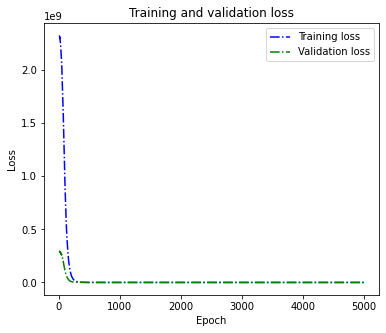

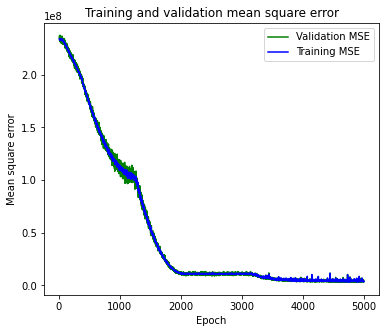

In [46]:
# Draw the trend of the loss and the MSE on the train and
# validation set during the training process respectively

# Prepare the data
train_loss = np.array(taxi_fit.history['loss'])
val_loss = np.array(taxi_fit.history['val_loss'])
train_eva = np.array(taxi_fit.history['mean_squared_error'])
val_eva = np.array(taxi_fit.history['val_mean_squared_error'])
inits = 10
epochs = np.array(range(inits, len(train_loss)))

# The trend of loss on the train and validation set
fig1 = plt.figure(figsize = (6, 5)); ax1 = plt.axes()
ax1.plot(epochs + 1, train_loss[epochs], 'b-.', label = 'Training loss')
ax1.plot(epochs + 1, val_loss[epochs], 'g-.', label = 'Validation loss')
ax1.set(xlabel = 'Epoch', ylabel = 'Loss',
        title = 'Training and validation loss')
ax1.legend()

# The trend of the metric (MSE) on the train and validation set
fig2 = plt.figure(figsize = (6, 5)); ax2 = plt.axes()
ax2.plot(epochs + 1, val_eva[epochs], 'g-', label = 'Validation MSE')
ax2.plot(epochs + 1, train_eva[epochs], 'b-', label = 'Training MSE')
ax2.set(xlabel = 'Epoch', ylabel = 'Mean square error',
        title = 'Training and validation mean square error')
ax2.legend()

# Evaluate the trained model on both train set and test set respectively
print(taxi_model.evaluate(taxi_train, verbose = 0))
print(taxi_model.evaluate(taxi_test, verbose = 0))

I take 10 samples from the test set. Then, I construct and visualize the 95% confidence intervals for the predictions of these samples.

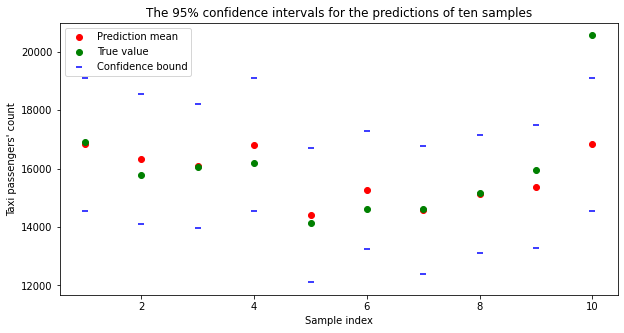

In [47]:
# Take 10 samples from the test set
num_exa = 10
features_exa, targets_exa = list(taxi_test.unbatch().batch(num_exa))[0]
features_exa = features_exa.numpy()
targets_exa = targets_exa.numpy()

# Compare the prediction means with the true labels
examples_mean = taxi_model(features_exa).mean().numpy()
examples_std = taxi_model(features_exa).stddev().numpy()

# Construct and visualize the 95% confidence intervals for the predictions
plt.figure(figsize = (10, 5))
index = range(1, num_exa + 1)
plt.scatter(index, examples_mean, color = 'red', label = 'Prediction mean')
plt.scatter(index, targets_exa, color = 'green', label = 'True value')
plt.scatter(index, examples_mean + 1.96*examples_std,
            color = 'blue', marker = '_', label = 'Confidence bound')
plt.scatter(index, examples_mean - 1.96*examples_std,
            color = 'blue', marker = '_')
plt.xlabel('Sample index'); plt.ylabel('Taxi passengers\' count')
plt.title('The 95% confidence intervals for the predictions of ten samples')
plt.legend()

Clear the model and re-train the model with the whole data set

In [48]:
# Clear the model and re-train the model with the whole data set

# Re-define the loss function in order to update the weight for the
# KL divergence loss between the surrogate posterior and weight prior
def negative_ELBO(label_true, label_pred):
    neg_log_likelihood = -tf.reduce_sum(label_pred.log_prob(label_true))
    kl = sum(taxi_model.losses)
    return neg_log_likelihood + kl/dataset_size

# Clear the model
BLSTM_layer1 = ed2.layers.LSTMCellFlipout(8, activation = 'sigmoid')
BLSTM_layer2 = ed2.layers.LSTMCellFlipout(16, activation = 'sigmoid')
taxi_model = tkeras.Sequential([
    tkeras.layers.Input(shape = (length, 2)),
    tkeras.layers.BatchNormalization(),
    tkeras.layers.RNN(cell = BLSTM_layer1, return_sequences = True),
    tkeras.layers.RNN(cell = BLSTM_layer2),
    tkeras.layers.Dense(units = 2),
    tfp.layers.IndependentNormal(1)
])

# Re-compile the model with the same settings
taxi_model.compile(
    optimizer = tkeras.optimizers.RMSprop(learning_rate = learning_rate),
    loss = negative_ELBO,
    metrics = [tkeras.metrics.mean_squared_error]
)

# Re-fit the model with the whole data set
taxi_model.fit(x = taxi_tfds.batch(dataset_size), epochs = num_epochs)

Epoch 1/5000
1/1 [==============================] - 5s 5s/step - loss: 1620676182016.0000 - mean_squared_error: 234335072.0000
Epoch 2/5000
1/1 [==============================] - 0s 398ms/step - loss: 3526136576.0000 - mean_squared_error: 233844336.0000
Epoch 3/5000
1/1 [==============================] - 0s 242ms/step - loss: 3523182336.0000 - mean_squared_error: 233839536.0000
Epoch 4/5000
1/1 [==============================] - 0s 168ms/step - loss: 3520073728.0000 - mean_squared_error: 233846320.0000
Epoch 5/5000
1/1 [==============================] - 0s 166ms/step - loss: 3516807936.0000 - mean_squared_error: 233844848.0000
Epoch 6/5000
1/1 [==============================] - 0s 178ms/step - loss: 3513373952.0000 - mean_squared_error: 233846336.0000
Epoch 7/5000
1/1 [==============================] - 0s 185ms/step - loss: 3509763840.0000 - mean_squared_error: 233839584.0000
Epoch 8/5000
1/1 [==============================] - 0s 174ms/step - loss: 3505970688.0000 - mean_squared_error:

Quantify and plot all kinds of uncertainties of the predictions

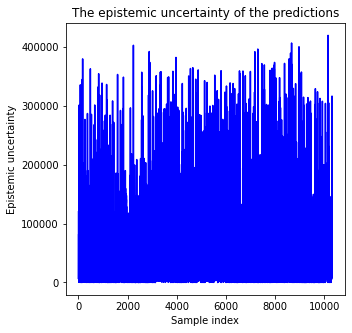

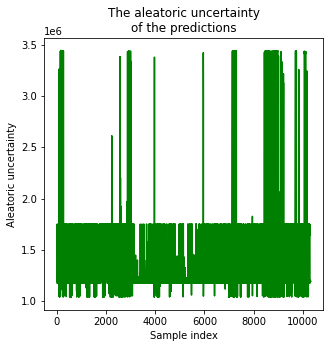

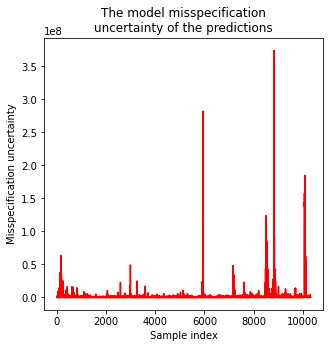

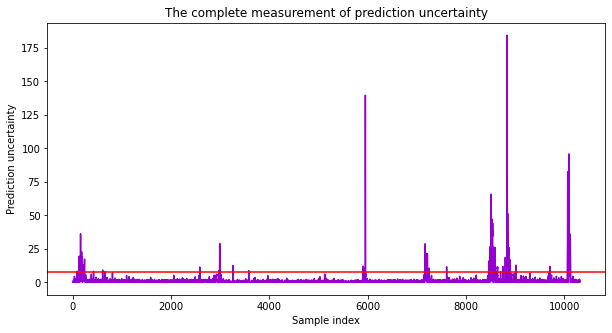

In [49]:
# Quantify all kinds of uncertainties of the predictions
N = 1000; records = np.zeros((N, dataset_size, 3))
for i in range(N):
    records[i, :, 0] = taxi_model(features).mean().numpy()[:, 0]
    records[i, :, 1] = taxi_model(features).variance().numpy()[:, 0]
    records[i, :, 2] = (taxi_model(features).mean().numpy()[:, 0] - labels.numpy())**2
epistemic = np.var(records[:, :, 0], axis = 0)
aleatoric = np.mean(records[:, :, 1], axis = 0)
misspecification = np.mean(records[:, :, 2], axis = 0)
P = 0; Q = 1/np.std(aleatoric); R = 6/np.std(misspecification)
W = -(Q*np.min(aleatoric) + R*np.min(misspecification))
comp_uncer = P*epistemic + Q*aleatoric + R*misspecification + W

# Plot all kinds of uncertainties
X = range(1, dataset_size + 1)

# Plot the epistemic uncertainty
plt.figure(figsize = (5, 5))
plt.plot(X, epistemic, 'b-')
plt.xlabel('Sample index')
plt.ylabel('Epistemic uncertainty')
plt.title('The epistemic uncertainty of the predictions')

# Plot the aleatoric uncertainty
plt.figure(figsize = (5, 5))
plt.plot(X, aleatoric, 'g-')
plt.xlabel('Sample index')
plt.ylabel('Aleatoric uncertainty')
plt.title('The aleatoric uncertainty\nof the predictions')

# Plot the model misspecification uncertainty
plt.figure(figsize = (5, 5))
plt.plot(X, misspecification, 'r-')
plt.xlabel('Sample index')
plt.ylabel('Misspecification uncertainty')
plt.title('The model misspecification\nuncertainty of the predictions')

# Plot the total prediction uncertainty
plt.figure(figsize = (10, 5))
plt.plot(X, comp_uncer, color = 'darkviolet')
plt.xlabel('Sample index')
plt.ylabel('Prediction uncertainty')
plt.title('The complete measurement of prediction uncertainty')
threshold = np.quantile(comp_uncer, 0.975)
plt.axhline(threshold, color = 'red')

# Adjust the vectors that contain all kinds of uncertainties
# in order to facilitate performing outlier detection
epistemic = np.hstack([0, epistemic])
aleatoric = np.hstack([0, aleatoric])
misspecification = np.hstack([0, misspecification])
comp_uncer = np.hstack([0, comp_uncer])

Visualize the result of outlier detection on Taxi data set using BLSTMNN

0.025
258


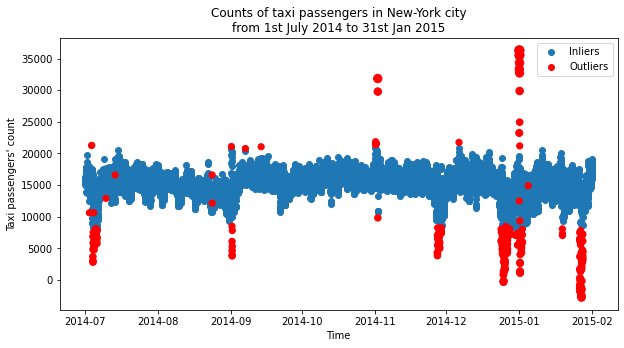

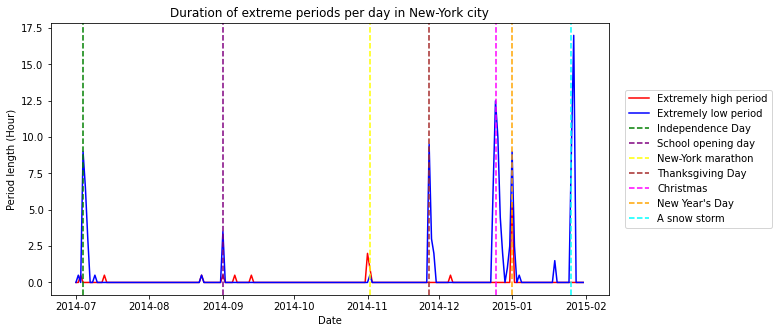

In [53]:
# Record the information about the index of outliers
threshold = np.quantile(comp_uncer, 0.975)
index = (comp_uncer > threshold)
n_outliers = np.sum(index)
print(np.mean(index)); print(n_outliers)

# Visualize the result of outlier detection on Taxi data set
# using Bayesian LSTM neural network
outliers = taxi_DeSeason[index]
inliers = taxi_DeSeason[(1 - index).astype('bool')]
fig = plt.figure(figsize = (10, 5)); ax = plt.axes()
ax.scatter(inliers.index, inliers.values, label = 'Inliers')
ax.scatter(outliers.index, outliers.values, color = 'red',
           s = plt.rcParams['lines.markersize']**2 + comp_uncer[index]/4)
ax.scatter([], [], color = 'red', label = 'Outliers')
ax.set(xlabel = 'Time', ylabel = 'Taxi passengers\' count',
       title = 'Counts of taxi passengers in New-York city\n' +
       'from 1st July 2014 to 31st Jan 2015')
plt.legend()

# Visualize the duration of the periods experiencing extremely high and extremely low
# taxi passenger numbers per day in New-York city respectively, and compare the dates
# of these extreme periods with the dates of special events happened in New York

# Prepare the data that we need
taxi_count = taxi.copy(); middle = 15000
taxi_count['value'] = taxi_DeSeason.values
large = []; small = []
for i in range(dataset_size + 1):
    x = 1 if (index[i] and taxi_DeSeason.values[i] > middle) else 0
    large.append(x)
    x = 1 if (index[i] and taxi_DeSeason.values[i] < middle) else 0
    small.append(x)
taxi_count['count_large'] = large
taxi_count['count_small'] = small
taxi_count = taxi_count.resample('D').sum().\
    apply(lambda x : 0.5*x).rename(columns = {'value' : 'busyness'})

# Visualize the duration of the extreme periods per day, and compare the
# dates of these extreme periods with the dates of special events in New-York
fig = plt.figure(figsize = (10, 5)); ax = plt.axes()
ax.plot(taxi_count.index, taxi_count['count_large'],
        color = 'red', label = 'Extremely high period')
ax.plot(taxi_count.index, taxi_count['count_small'],
        color = 'blue', label = 'Extremely low period')
events = ['Independence Day', 'School opening day', 'New-York marathon',
          'Thanksgiving Day', 'Christmas', 'New Year\'s Day', 'A snow storm']
dates = [pd.Timestamp('2014-7-4'), pd.Timestamp('2014-9-1'),
         pd.Timestamp('2014-11-2'), pd.Timestamp('2014-11-27'),
         pd.Timestamp('2014-12-25'), pd.Timestamp('2015-1-1'),
         pd.Timestamp('2015-1-26')]
colors = ['green', 'purple', 'yellow', 'brown', 'fuchsia', 'orange', 'cyan']
for event, date, color in zip(events, dates, colors):
    ax.axvline(date, label = event, color = color, linestyle = '--')
ax.set(xlabel = 'Date', ylabel = 'Period length (Hour)',
       title = 'Duration of extreme periods per day in New-York city')
plt.legend(bbox_to_anchor = (1.03, 0.5), loc = 6, borderaxespad = 0)

Perform outlier detection on Taxi data set using LOF and DBSCAN method respectively, and visualize the results of these two methods

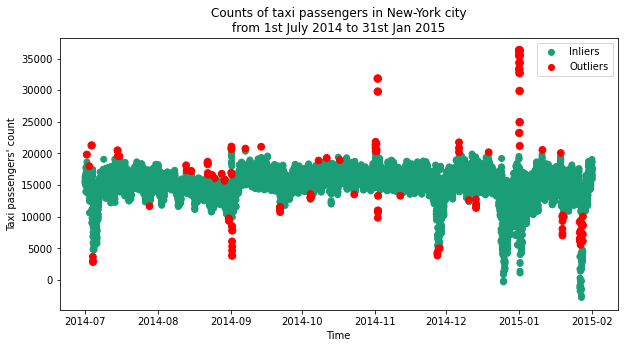

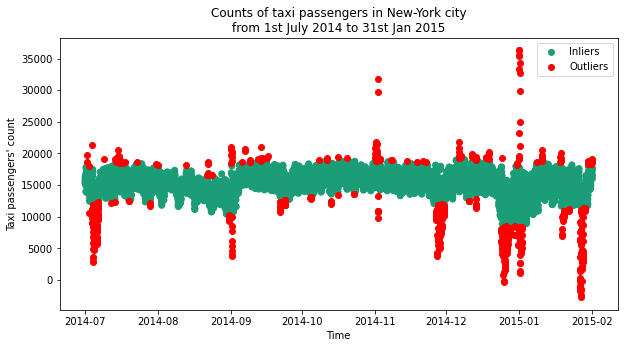

In [54]:
# Prepare data for the LOF method and DBSCAN method
dataset_size = len(taxi_DeSeason)
taxi_detect = pd.DataFrame(
    np.array([range(dataset_size), taxi_DeSeason.values]).T,
    columns = ['time', 'counts']
)

# Outlier detection on Taxi data set using Local Outlier Factor method
Lof = LocalOutlierFactor(); offset_ = -1.45
Lof.fit(taxi_detect)
Lof_fac = Lof.negative_outlier_factor_
Lof_pre = -(Lof_fac < offset_).astype('int')
index_out = (Lof_pre == -1); index_in = (1 - index_out).astype('bool')
outliers = taxi_DeSeason[index_out]; inliers = taxi_DeSeason[index_in]

# Visualize the result of outlier detection on Taxi data set using LOF method
fig = plt.figure(figsize = (10, 5)); ax = plt.axes()
ax.scatter(inliers.index, inliers.values, c = Lof_pre[index_in],
           cmap = plt.cm.Dark2, label = 'Inliers')
ax.scatter(outliers.index, outliers.values, color = 'red',
           s = plt.rcParams['lines.markersize']**2 - 6*Lof_fac[index_out])
ax.scatter([], [], color = 'red', label = 'Outliers')
ax.set(xlabel = 'Time', ylabel = 'Taxi passengers\' count',
       title = 'Counts of taxi passengers in New-York city\n' +
       'from 1st July 2014 to 31st Jan 2015')
plt.legend()

# Outlier detection on Taxi data set using DBSCAN method
DBSCAN_model = DBSCAN(eps = 380, min_samples = 20)
DBSCAN_fit = DBSCAN_model.fit(taxi_detect)
DBSCAN_pre = DBSCAN_fit.labels_
index_noise = (DBSCAN_pre == -1); index_in = (1 - index_noise).astype('bool')
noise = taxi_DeSeason[index_noise]; inliers = taxi_DeSeason[index_in]

# Visualize the result of outlier detection on Taxi data set using DBSCAN method
fig = plt.figure(figsize = (10, 5)); ax = plt.axes()
ax.scatter(inliers.index, inliers.values, c = DBSCAN_pre[index_in],
           cmap = plt.cm.Dark2, label = 'Inliers')
ax.scatter(noise.index, noise.values, color = 'red', label = 'Outliers')
ax.set(xlabel = 'Time', ylabel = 'Taxi passengers\' count',
       title = 'Counts of taxi passengers in New-York city\n' +
       'from 1st July 2014 to 31st Jan 2015')
plt.legend()